# 🔁 LSTM Modeling for Sequential Usage Patterns

In this notebook, we:
- Load sequential user behavior data
- Reshape into [samples, timesteps, features]
- Build and train an LSTM classifier
- Evaluate performance

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4354 - loss: 0.6897 - val_accuracy: 0.8750 - val_loss: 0.6592
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7792 - loss: 0.6720 - val_accuracy: 0.8750 - val_loss: 0.6271
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7708 - loss: 0.6413 - val_accuracy: 0.8750 - val_loss: 0.5787
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8292 - loss: 0.5925 - val_accuracy: 0.8750 - val_loss: 0.4916
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7771 - loss: 0.5398 - val_accuracy: 0.8750 - val_loss: 0.3814
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8625 - loss: 0.4576 - val_accuracy: 0.8750 - val_loss: 0.3954
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8417 - loss: 0.4651 - val_accuracy: 0.8750 - val_loss: 0.3753
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8062 - loss: 0.5246 - val_accuracy: 0.8750 - val_loss: 0.3994

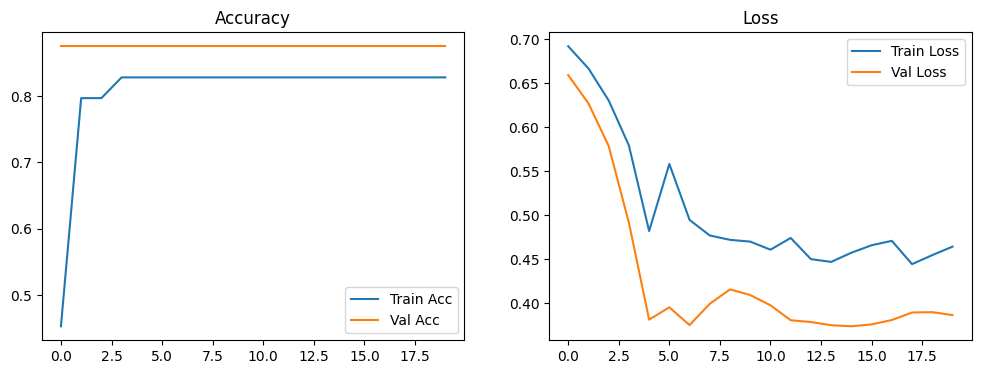

In [12]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🧪 Step 1: Generate mock daily usage data
np.random.seed(42)

customers = [f"CUST_{i:03}" for i in range(1, 101)]  # 100 customers
dates = pd.date_range(end=pd.Timestamp.today(), periods=30)

data = []
for cust in customers:
    for date in dates:
        data.append({
            "customer_id": cust,
            "date": date,
            "usage_count": np.random.poisson(2),
            "interaction_rate": np.random.rand(),
            "avg_duration": np.random.uniform(5, 25)
        })

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# 🧠 Step 2: Simulate churn labels
churn_labels = pd.DataFrame({
    "customer_id": customers,
    "churn": np.random.choice([0, 1], size=len(customers), p=[0.8, 0.2])  # 20% churn
})

# 🔄 Step 3: Pivot to wide format for LSTM
features = ['usage_count', 'interaction_rate', 'avg_duration']
pivoted = df.pivot(index='customer_id', columns='date', values=features)
pivoted = pivoted.sort_index(axis=1, level=1)  # Ensure dates are sorted

# 📐 Step 4: Reshape for LSTM (n_samples, timesteps, n_features)
X = pivoted.values.reshape(len(pivoted), 30, len(features))

# 🔢 Step 5: Prepare target
y = churn_labels.set_index("customer_id").loc[pivoted.index, "churn"].values

# 📊 Optional: Standardize features
scaler = StandardScaler()
X_scaled = X.copy()
for i in range(X.shape[0]):
    X_scaled[i] = scaler.fit_transform(X[i])

# 🧪 Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🤖 Step 7: Build LSTM model
model = Sequential()
model.add(Input(shape=(30, len(features))))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 🏋️‍♂️ Step 8: Train
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)


# 📈 Step 9: Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# 📉 Optional: Plot accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title("Loss")
plt.show()


In [13]:
df.to_csv("../data/raw/lstm_usage_logs.csv", index=False)
churn_labels.to_csv("../data/raw/customer_labels.csv", index=False)

In [14]:
# 💾 Save the trained LSTM model
from pathlib import Path

Path("../models").mkdir(parents=True, exist_ok=True)
model.save("../models/lstm_churn_model.h5")
print("✅ LSTM model saved to /models/lstm_churn_model.h5")


✅ LSTM model saved to /models/lstm_churn_model.h5
